##### Figure 5abc
# HRRR and MesoWest Cumulative Distribution

Single Hour

- MesoWest percentile calculations retreived from MesoWest API  
- HRRR percentile calculations generated by the OSG

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from mpl_toolkits.basemap import Basemap

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_nearesttime import get_mesowest_nearesttime
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new
from BB_wx_calcs.wind import wind_uv_to_spd

In [2]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b')

import matplotlib as mpl 
two_column = 6.5
one_column = 3.2
twothird_column = 5.5
mpl.rcParams['figure.figsize'] = [one_column, 2.8]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 1000    # 600 for print

AMS Journal Figure size chart.  
_Note: Figsize parameter may differ from what is actually generated_

| One Colulmn | 2/3 Page   | Two Columns   | More than 2 columns  |
|---|---|---|---|
| 3.2   | 4.5  | 5.5  | 6.5  |


## Get lat/lon HRRR grid

In [3]:
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

### Function: Get a point from the OSG percentile grid

In [4]:
def get_point_percentiles(DATE):
    ## PP stands for Percentiles Point
    if DATE.day == 1 and DATE.hour == 0:
        print 'Working on', DATE
    
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, DATE.month, DATE.day, DATE.hour))
    
    PP = np.array([])
    with h5py.File(DIR+FILE, 'r') as f:
        for i in percentiles:
            PP = np.append(PP, f["p%02d" % i][x][y])
    
    # Convert Units
    if var == 'TMP:2 m' or var == 'DPT:2 m':
        PP -= 273.15
    
    return PP

-------

## Input Arguments
statistic can be from the list:  
`mean, p00, p01, p02, p03, p04, p05, p10, p15, p25, p33, p50, p66, p75, p90, p95, p96, p97, p98, p99, p100`

In [5]:
percentiles = [0, 1, 2, 3, 4, 5, 10, 25, 33, 50, 66, 75, 90, 95, 96, 97, 98, 99, 100]
var = 'UVGRD:10 m'
stn = 'HWKC1'
fxx = 0

# Date of interest
leapyear = 2016
DATE = datetime(leapyear, 10, 9, 6)

In [8]:
# Additional Setup
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group8/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

if var == 'TMP:2 m':
    MWvar = 'air_temp'
    label = '2 m Temperature (C)'
elif var == 'DPT:2 m':
    MWvar = 'dew_point_temperature'
    label = '2 m Dew Point Temperature (C)'
elif var == 'UVGRD:10 m':
    MWvar = 'wind_speed'
    label = r'10 m Wind Speed (m s$\mathregular{^{-1}}$)'
    MWlabel = r'Wind Speed (m s$\mathregular{^{-1}}$)'
elif var == 'UVGRD:80 m':
    MWvar = 'wind_speed'
    label = r'80 m Wind Speed (m s$\mathregular{^{-1}}$)'
else:
    MWvar = ''
    print "NO MATCHING VAR AND MESOWEST VAR"

# Fig 5a

## Get HRRR Percentiles (Cumulative Distribution) nearest MesoWest Station of Interest
From the OSG files

In [9]:
# Get Time Series Data for each requested Statistic
# HTS is the HRRR-statistic Time Series

# Pluck point nearest MesoWest Station
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']
point = pluck_point_new(MWlat, MWlon, lat, lon)
x = point[0][0]
y = point[1][0]

# HRRR Cumulative Distribution
HR_CD = get_point_percentiles(DATE)

## Get MesoWest Percentiles (Cumulatie Distribution)
From MesoWest API

In [10]:
start = DATE.strftime('%m%d%H')
end = start

MW_per = get_mesowest_percentiles(stn, variable=MWvar, start=start, end=end, percentiles='ALL', v=True)
print 'MesoWest Station: %s \t Variable: %s' % (stn, MWvar)
print 'Max Years: %s \t Max Count: %s' % (MW_per['years'].max(), MW_per['counts'].max()) 
print 'Min Years: %s \t Min Count: %s' % (MW_per['years'].min(), MW_per['counts'].min())

# Observed Cumulative Distribution
MW_CD = []
for i in percentiles:
    MW_CD.append(MW_per['p%02d'%i][0])

# Get HRRR percentiles from MesoWest API (not most up to date)
#HR_per = get_mesowest_percentiles(stn, variable=MWvar, psource='PERCENTILES_HRRR')
#print '\nHRRR Grid: %s' % stn
#print 'Max Count: %s' % (HR_per['counts'].max()) 
#print 'Min Count: %s' % (HR_per['counts'].min())

MesoWest API Query:  http://api.synopticlabs.org/v2/percentiles?&token=2562b729557f45f5958516081f06c9eb&start=100906&end=100906&vars=wind_speed&stid=HWKC1&psource=PERCENTILES2
MesoWest Station: HWKC1 	 Variable: wind_speed
Max Years: 18 	 Max Count: 551
Min Years: 18 	 Min Count: 551


## Print HRRR and MesoWest Cumulative Distribution Values

In [11]:
print 'Station: %s' % stn
print 'Percentile\t HRRR \tMesoWest'
for i, P in enumerate(percentiles):
    print '  p%02d \t\t  %.2f\t %.2f' % (P, HR_CD[i], MW_CD[i])

Station: HWKC1
Percentile	 HRRR 	MesoWest
  p00 		  0.92	 0.00
  p01 		  0.99	 0.00
  p02 		  1.48	 0.00
  p03 		  1.79	 0.45
  p04 		  1.91	 0.45
  p05 		  2.04	 0.45
  p10 		  2.44	 0.90
  p25 		  3.40	 1.34
  p33 		  3.50	 1.79
  p50 		  4.26	 2.23
  p66 		  5.12	 3.58
  p75 		  6.08	 4.02
  p90 		  8.23	 5.37
  p95 		  8.77	 6.70
  p96 		  8.96	 7.60
  p97 		  9.26	 8.49
  p98 		  10.12	 8.94
  p99 		  12.80	 10.28
  p100 		  16.42	 18.78


## Create Figure

DATE: Oct-09 06:00 UTC
 STN: HWKC1


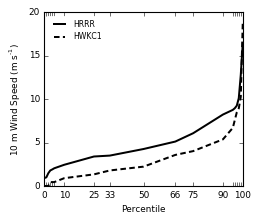

In [12]:
# Plot Percentile Curve
plt.plot(percentiles, HR_CD,
         color='k',
         label='HRRR')
plt.plot(percentiles, MW_CD,
         color='k',
         linestyle='--', dashes=(5, 3),
         label=stn)

#plt.scatter(100, MW_event_value, s=100)
#plt.scatter(100, HR_event_value, s=100)

#plt.grid()

plt.xlabel('Percentile')
tick_labels = [0,'','','','','', 10, 25, 33, 50, 66, 75, 90, '', '', '', '','',100]
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel('%s' % (label))

if var in ['UVGRD:10 m', 'UVGRD:80 m', 'WIND:10 m', 'GUST:surface']:
    plt.ylim(ymin=0)
else:
    pass

legend = plt.gca().legend(frameon=True, framealpha=.8, loc=2)
legend.get_frame().set_linewidth(0)
    
#plt.title('%s' % DATE.strftime('%b-%d %H:%M UTC'), loc='Left')
#plt.title('%s' % (stn), fontweight='bold', loc='right')
plt.savefig('./figs/Fig_05a_CD_%s_%s_%s' % (stn.upper(), variable, DATE.strftime('m%m_d%d_h%H')))

print 'DATE: %s' % DATE.strftime('%b-%d %H:%M UTC')
print ' STN: %s' % stn

## Get HRRR Percentiles (Cumulative Distribution) for an area

In [15]:
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group8/blaylock/HRRR_OSG/hourly30/%s/' % (variable)
FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, DATE.month, DATE.day, DATE.hour))

box_radius = 5

with h5py.File(DIR+FILE, 'r') as ff:
    for i in percentiles:
        pp = ff["p%02d" % i][x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]
        if i == 0:
            PP = pp
        else:
            PP = np.dstack([PP, pp])

## Convert Units
if var == 'TMP:2 m' or var == 'DPT:2 m':
    PP -= 273.15

## Clalculate area percentiles for each percentile from the OSG percentiles
for i, percentile in enumerate(percentiles):
    p = np.percentile(PP[:,:,i], [0, 1, 2, 3, 4, 5, 25, 50, 75, 95, 96, 97, 98, 99, 100])
    if i == 0:
        area_P = p
    else:
        area_P = np.dstack([area_P, p])

Border Box: 33x33 km box centered at HWKC1


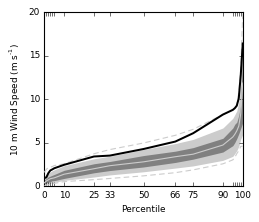

In [16]:
## --- Plot OSG percentiles ---------------------------------------
plt.fill_between(percentiles, area_P[0][5], area_P[0][-6],
                 label='p05-p95',
                 facecolor=[.8, .8, .8],
                 linewidth=0,
                 zorder=1)
plt.fill_between(percentiles, area_P[0][6], area_P[0][-7],
                 facecolor=[.5, .5, .5],
                 linewidth=0,
                 label='p25-p75',
                 zorder=1)

plt.plot(percentiles, area_P[0][7],
         color=[.8, .8, .8],
         linewidth=1,
         zorder=10)

# Plot Max and Min Percentiles
for per in [0, -1]:
    plt.plot(percentiles, area_P[0][per],
             color=[.8, .8, .8],
             linestyle='--', dashes=(5,3),
             linewidth=1,
             zorder=10)

## Plot OSG percentiles for the single grid box nearest the station of interest
plt.plot(percentiles, HR_CD,
         color='k',
         label='%s OSG Percentiles' % stn,
         zorder=100)

## --- Other Plot Elements --------------------------------------
#plt.title('%sx%s km box centered at' % (np.shape(PP)[0]*3, np.shape(PP)[0]*3), loc='left')
#plt.title('%s' % (stn), fontweight='semibold', loc='right')
plt.xlabel('Percentile')
tick_labels = [0,'','','','','', 10, 25, 33, 50, 66, 75, 90, '', '', '', '','',100]
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel('%s' % (label))

if var in ['UVGRD:10 m', 'UVGRD:80 m', 'WIND:10 m', 'GUST:surface']:
    plt.ylim(ymin=0)
else:
    pass

plt.savefig('./figs/Fig_05b_area_percentiles_%s' % stn)

print "Border Box: %sx%s km box centered at %s" % (np.shape(PP)[0]*3, np.shape(PP)[0]*3, stn)

## Area percentiles bounding box inset

In [17]:
LATS_BOX = lat[x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]
LONS_BOX = lon[x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]

top_right_lat = LATS_BOX.max()
top_right_lon = LONS_BOX.min()

bot_left_lat = LATS_BOX.min()
bot_left_lon = LONS_BOX.max()


m = Basemap(llcrnrlon=MWlon-.3,  urcrnrlon=MWlon+.3,
            llcrnrlat=MWlat-.3, urcrnrlat=MWlat+.3)

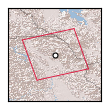

In [19]:
plt.figure(figsize=[1.5, 1.5])
m.drawcounties()
m.arcgisimage(service='World_Shaded_Relief', xpixels=1000, dpi=1000)

#m.pcolormesh(LONS_BOX, LATS_BOX, np.ones_like(LONS_BOX), alpha=.4)
m.scatter(MWlon, MWlat, color='white', edgecolor='k')

# Bottom Boundary
m.drawgreatcircle(LONS_BOX[0,-1], LATS_BOX[0,-1],
                  LONS_BOX[0,0], LATS_BOX[0,0],
                  color='crimson',
                  linewidth=.8)

# Left Boundary
m.drawgreatcircle(LONS_BOX[0,0], LATS_BOX[0,0],
                  LONS_BOX[-1,0], LATS_BOX[-1,0],
                  color='crimson',
                  linewidth=.8)

# Top Boundary
m.drawgreatcircle(LONS_BOX[-1,-1], LATS_BOX[-1,-1],
                  LONS_BOX[-1,0], LATS_BOX[-1,0],
                  color='crimson',
                  linewidth=.8)

# Right Boundary
m.drawgreatcircle(LONS_BOX[-1,-1], LATS_BOX[-1,-1],
                  LONS_BOX[0,-1], LATS_BOX[0,-1],
                  color='crimson',
                  linewidth=.8)

plt.savefig('./figs/Fig_05b_area_map_%s_inset' % stn, transparent=True)

---
## Print value from a specific event
For comparison


In [20]:
event_datetime = datetime(2017, 10, 9, 6)

# HRRR values
if var.split(':')[0] == 'UVGRD':
    Hu = get_hrrr_variable(event_datetime, 'UGRD:10 m', verbose=False)
    Hv = get_hrrr_variable(event_datetime, 'VGRD:10 m', verbose=False)
    H = Hu.copy()
    H['value'] = wind_uv_to_spd(Hu['value'], Hv['value'])
else:
    H = get_hrrr_variable(event_datetime, var, verbose=False)

HR_event_value = H['value'][x][y]

In [21]:
a = get_mesowest_nearesttime(event_datetime, stn, variables=MWvar)

MW_event_value = a[stn][MWvar]['value']

In [22]:
print 'Variable\t:', var
print '-----------------------------------'
print 'HRRR Analysis\t: %s\t%s' % (HR_event_value, event_datetime)
print 'Observed value\t: %s\t\t%s' % (MW_event_value, a[stn][MWvar]['DATETIME'])

Variable	: UVGRD:10 m
-----------------------------------
HRRR Analysis	: 16.4177	2017-10-09 06:00:00
Observed value	: 18.78		2017-10-09 05:56:00


# Fig 5c

## Get HRRR Percentiles
From the OSG files

In [23]:
# Hours
hours = [0, 6, 12, 18]

In [24]:
# Get Time Series Data for each requested Statistic
# HTS is the HRRR-statistic Time Series

# Pluck point nearest MesoWest Station
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']
point = pluck_point_new(MWlat, MWlon, lat, lon)
x = point[0][0]
y = point[1][0]

PP = {}
for i in hours:
    DATETIME = datetime(leapyear, DATE.month, DATE.day, i)
    PP[i] = get_point_percentiles(DATETIME)

## Get MesoWest Percentiles
From MesoWest API

In [25]:
MW_PDF = {}
for h in hours:
    DATETIME = datetime(leapyear, DATE.month, DATE.day, h)
    start = DATETIME.strftime('%m%d%H')
    end = start

    MW_per = get_mesowest_percentiles(stn, variable=MWvar, start=start, end=end, percentiles='ALL')
    
    MW_pdf = []
    for i in percentiles:
        MW_pdf.append(MW_per['p%02d'%i][0])
    
    MW_PDF[h] = MW_pdf

## HRRR vs MesoWest

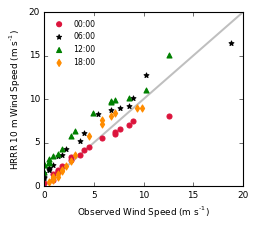

In [26]:
C = ['crimson', 'black', 'green', 'darkorange']
M = ['o', '*', '^', 'd']

plt.plot(range(21),range(21), color=[.75,.75,.75], zorder=1)

# MesoWest CD vs HRRR CD
for i, hour in enumerate(hours):
    plt.scatter(MW_PDF[hour], PP[hour],
             color=C[i],
             marker=M[i],
             label='%02d:00' % hour,
             zorder=2)

    
plt.xlabel('Observed %s' % (MWlabel))
plt.ylabel('HRRR %s' % (label))
plt.ylim([0,20])
plt.xlim([0,20])

if var in ['UVGRD:10 m', 'UVGRD:80 m', 'WIND:10 m', 'GUST:surface']:
    plt.ylim(ymin=0)
else:
    pass

legend = plt.gca().legend(frameon=True, framealpha=.8, loc=2, scatterpoints=1)
legend.get_frame().set_linewidth(0)
plt.savefig('./figs/Fig_05c_CD_compare_%s_%s_%s' % (stn.upper(), variable, DATE.strftime('m%m_d%d_h00-h06-h12-h18')))

In [27]:
print "Obs\tHRRR\tDifference"
for i, MW in enumerate(MW_PDF[6]):
    print MW, '\t',PP[6][i], '\t', MW-PP[6][i]
    
print 'Mean Absolute Difference:', np.mean((MW_PDF[6][:-1]-PP[6][:-1]))

Obs	HRRR	Difference
0.0 	0.916 	-0.916
0.0 	0.995 	-0.995
0.0 	1.475 	-1.475
0.45 	1.793 	-1.343
0.45 	1.909 	-1.459
0.45 	2.043 	-1.593
0.9 	2.444 	-1.544
1.34 	3.398 	-2.058
1.79 	3.503 	-1.713
2.23 	4.262 	-2.032
3.58 	5.119 	-1.539
4.02 	6.08 	-2.06
5.37 	8.23 	-2.86
6.7 	8.77 	-2.07
7.6 	8.965 	-1.365
8.49 	9.256 	-0.766
8.94 	10.119 	-1.179
10.28 	12.796 	-2.516
18.78 	16.418 	2.362
Mean Absolute Difference: -1.63794444444
